<b>UCI Dataset: Bank Marketing</b>

Um Kernel por Tibor Zequini.


In [32]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

Vamos começar fazendo uma breve exploração dos dados.

In [33]:
# Loading data
df = pd.read_csv('Data/bank-full.csv', sep=';')

# Binarizando o output
mapp = {'no':0, 'yes':1}
df['y'] = df['y'].apply(lambda row: mapp[row])

df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,0


In [34]:
# Brief description
df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


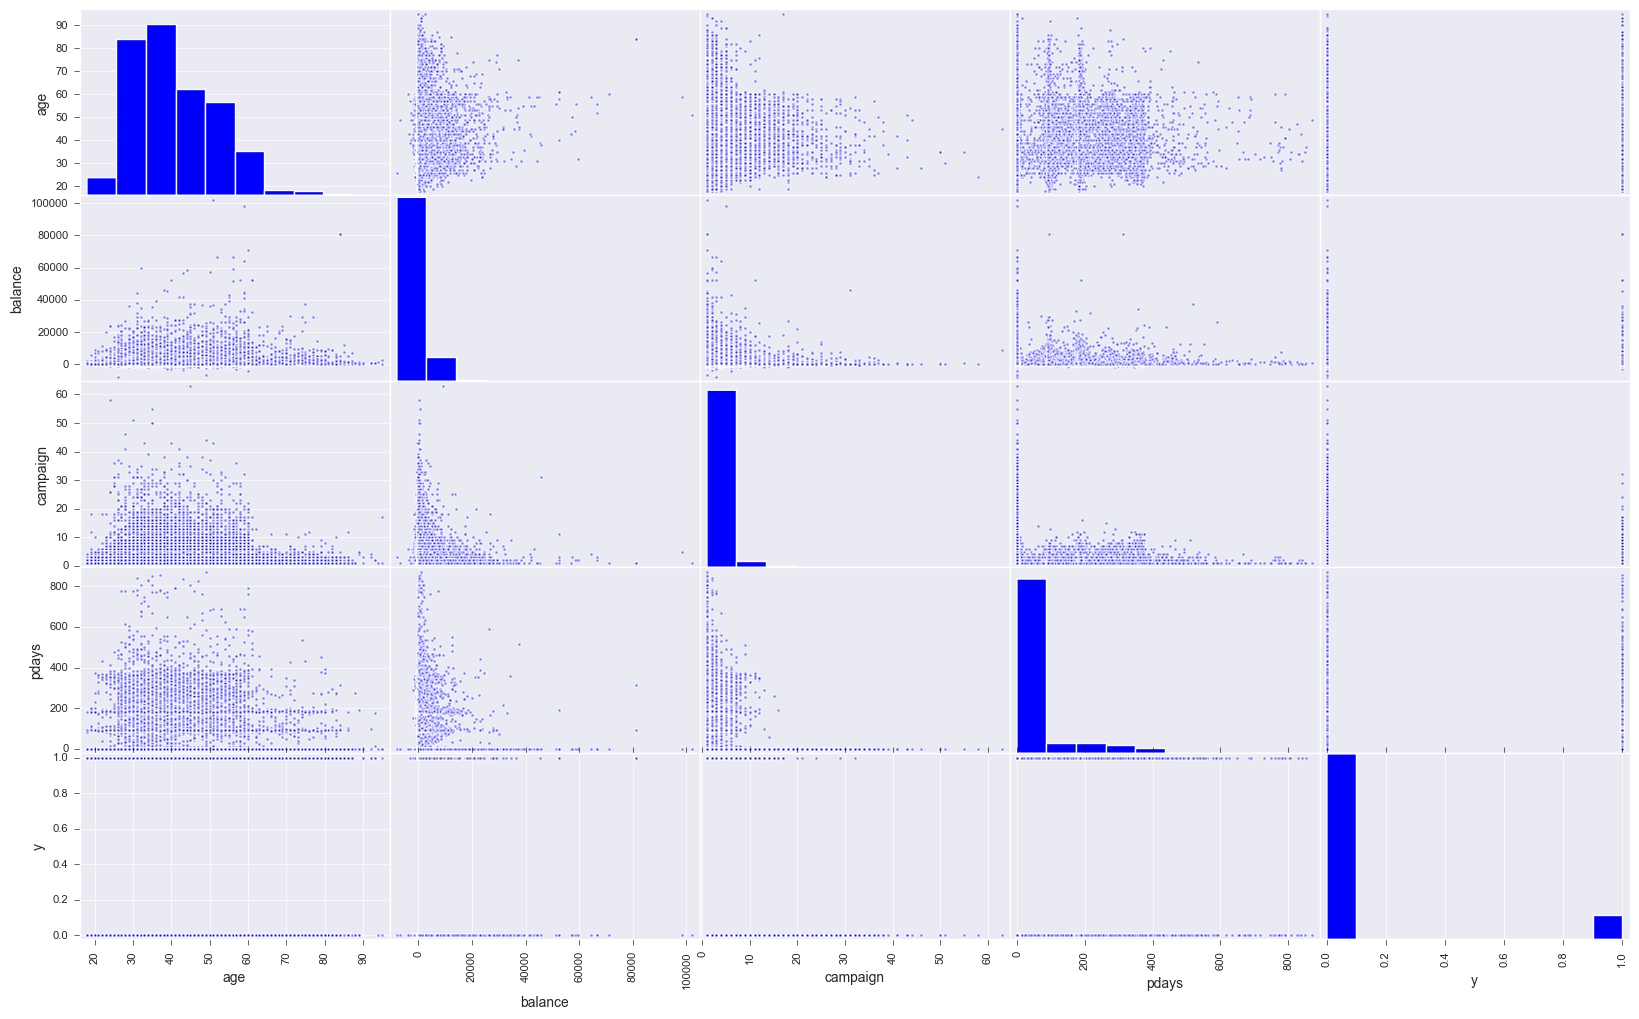

In [4]:
pd.scatter_matrix(df[['age', 'balance', 'campaign', 'pdays', 'y']], figsize=(20, 12))
plt.show()

Com uma visão panorâmica do que é cada atributo, quais são numéricos e categóricos, e algumas relações fornecidas pelo scatter, podemos começar a responder às perguntas.

___
<b>1.</b> (a) Qual profissão tem mais tendência a fazer um empréstimo?

Verificando os tipos de dados previamente, para não carregar erros pras próximas etapas.

In [5]:
df['housing'].unique(), df['loan'].unique()

(array(['yes', 'no'], dtype=object), array(['no', 'yes'], dtype=object))

Existem dois tipos de empréstimos, o pessoal e o imobiliário. 

Para descobrir quais as profissões de maior tendência a realizar empréstimo, toma-se a porcentagem de empréstimos realizadas por profissão, e em seguida é possível realizar um ordenamento para verificação.

Primeiramente, iremos fazer uma inspeção de quantos clientes estão contidas em cada profissão:

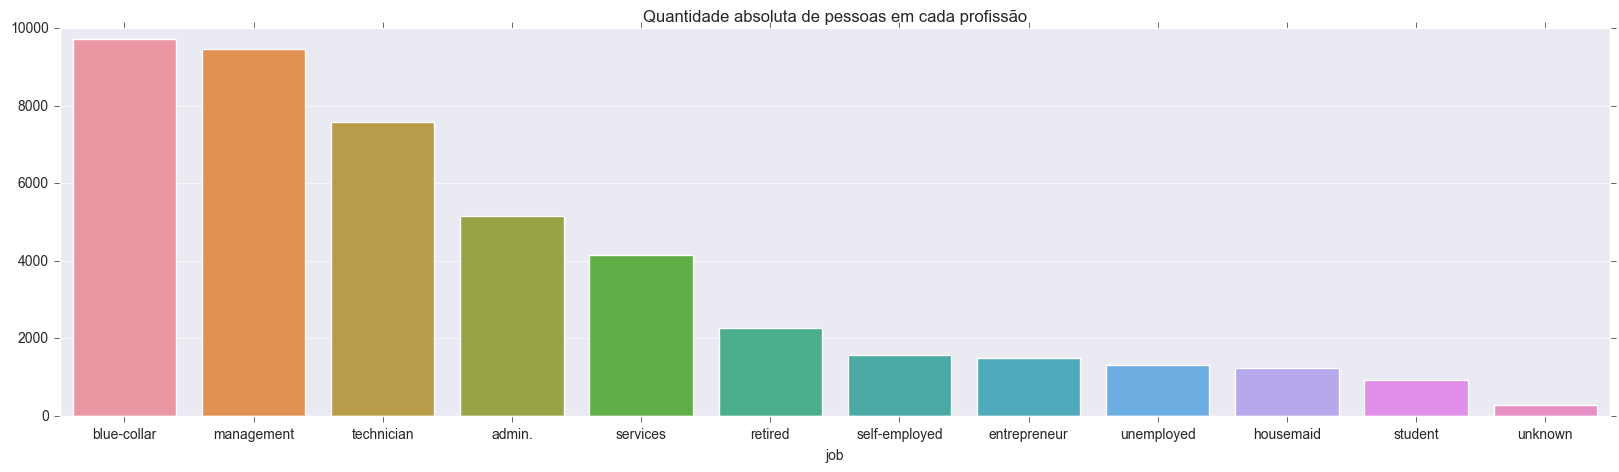

In [6]:
counter = df[['job', 'loan']].pivot_table(columns='job', values='loan', aggfunc='count').reset_index()
plt.figure(figsize=(20,5))
sns.barplot(x='job', y='loan', data=counter.sort_values(by='loan', ascending=False))
plt.title('Quantidade absoluta de pessoas em cada profissão')
plt.ylabel('')
plt.show()

Agora iremos olhar, em números absolutos, o número de empréstimos por profissão, para isso, iremos binarizar as colunas 'loan' e 'housing' para 0 e 1, denotando 'no' e 'yes', respectivamente.

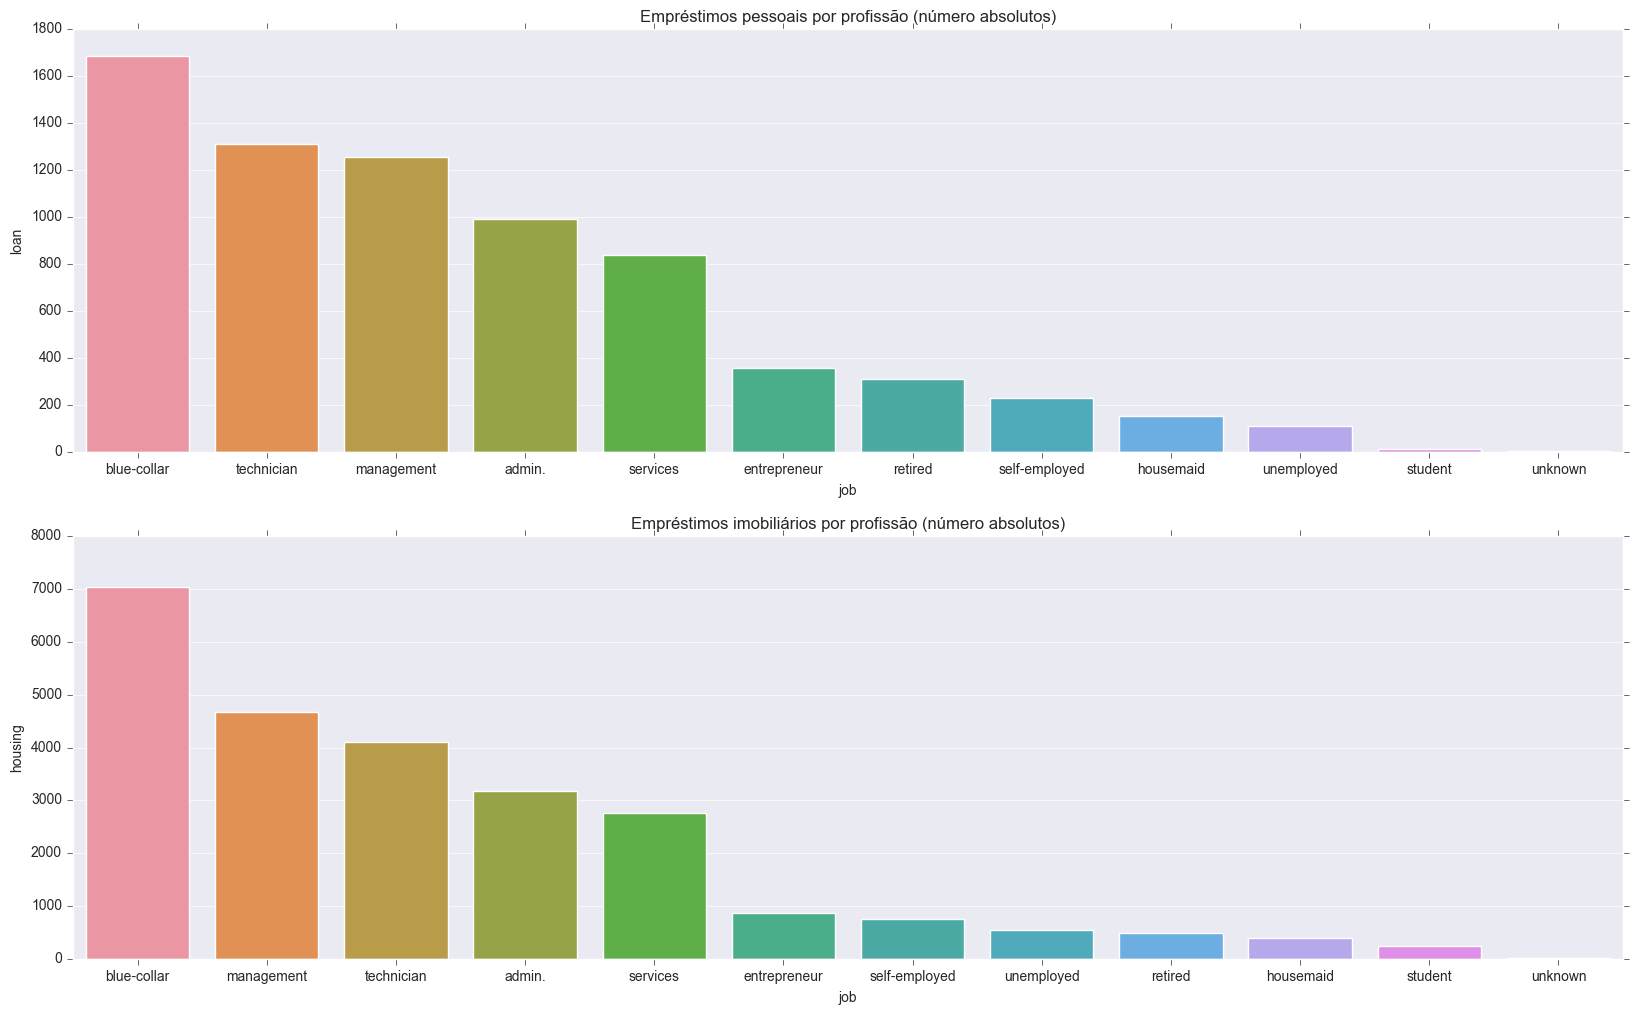

In [7]:
# Agrupando os empréstimos por profissão
mapping = {'no':0, 'yes':1}
df_job_pers = pd.concat([df.drop(['loan'], axis=1), df['loan'].apply(lambda x: mapping[x])], axis=1).groupby('job').sum()[['loan']]
df_job_hous = pd.concat([df.drop(['housing'], axis=1), df['housing'].apply(lambda x: mapping[x])], axis=1).groupby('job').sum()[['housing']]

# Plot
fig, ax = plt.subplots(2,1 , figsize=(20,12))
plt.title('Quantidade absoluta de empréstimos por profissão')
sns.barplot(x='job', y='loan', data=df_job_pers.reset_index().sort_values(by='loan', ascending=False), ax=ax[0])
ax[0].set_title('Empréstimos pessoais por profissão (número absolutos)')
sns.barplot(x='job', y='housing', data=df_job_hous.reset_index().sort_values(by='housing', ascending=False), ax=ax[1])
ax[1].set_title('Empréstimos imobiliários por profissão (número absolutos)')
plt.show()

Agora, olharemos o número percentual de cada empréstimo por profissão. 

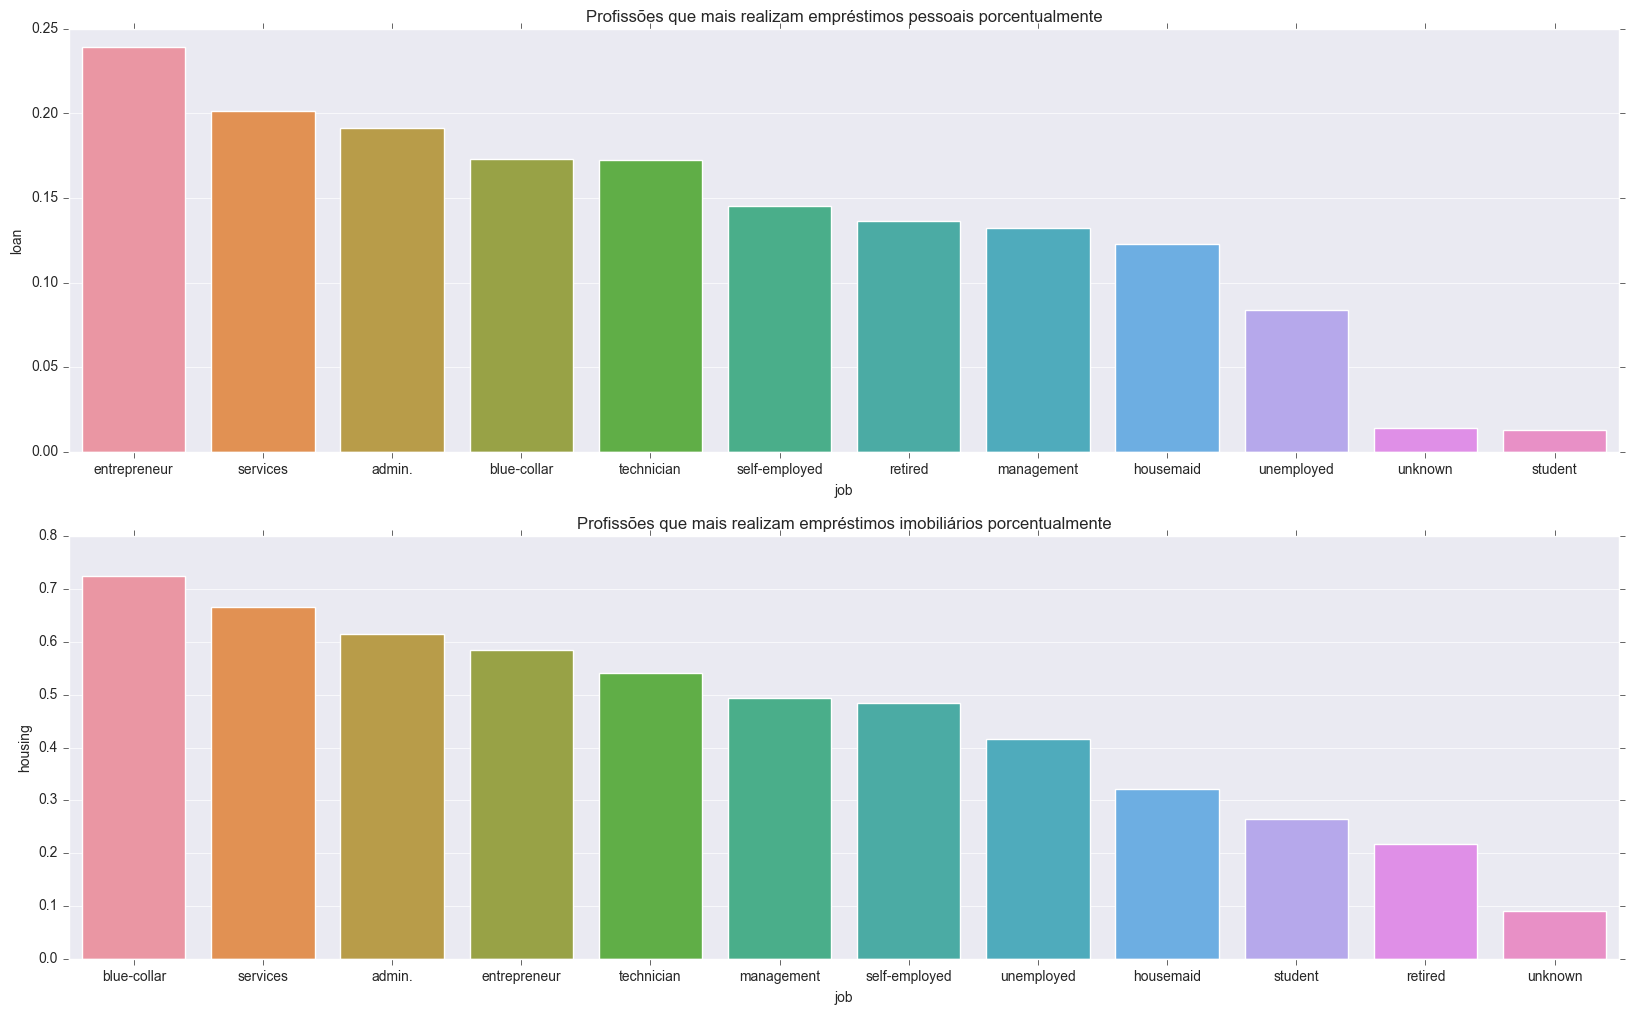

In [8]:
# Fazendo o percentual
df_job_pers_perc = df_job_pers / df[['job', 'loan']].groupby('job').count()
df_job_hous = df_job_hous / df[['job', 'housing']].groupby('job').count()

# Plot
fig, ax = plt.subplots(2,1,figsize=(20,12))
ax[0].set_title('Profissões que mais realizam empréstimos pessoais porcentualmente')
sns.barplot(x='job', y='loan', data=df_job_pers_perc.reset_index().sort_values(by='loan', ascending=False), ax=ax[0])
ax[1].set_title('Profissões que mais realizam empréstimos imobiliários porcentualmente')
sns.barplot(x='job', y='housing', data=df_job_hous.reset_index().sort_values(by='housing', ascending=False), ax=ax[1])
plt.show()

Deixe as variáveis aleatórias $X_1, ... X_k$ representarem os pedidos de empréstimo imobiliário pela $k$-ésima profissão, e $Y_1, ... Y_k$ representarem os pedidos de empréstimo pessoal também pela $k$-ésima profissão. 

Então, $X_1,...,X_k, Y_1, ..., Y_k$ seguem distribuições de Bernoulli de parâmetros conhecidos $p_{11},...,p_{1k}, p_{21}, ... p_{2k}$, respectivamente.

Para saber qual a profissão com maior tendência a realizar empréstimo, resolve-se o seguinte problema,

$$\hat{k} = \arg \max _k  P(X_k=1 \cup Y_k=1)$$

E, portanto, 

$$\hat{k} = \arg \max _k  P(X_k=1\cup Y_k=1) = \arg \max _k  P(X_k=1) + P(Y_k=1) - P(X_k=1, Y_k=1)$$

Entretanto, é razoável assumir a independência entre o pedido de ambos empréstimos (apesar de nem sempre ser verdade), daí,

$$\hat{k} = \arg \max _k  P(X_k=1\cup Y_k=1) = \arg \max _k  P(X_k=1) + P(Y_k=1) - P(X_k=1)P(Y_k=1)$$


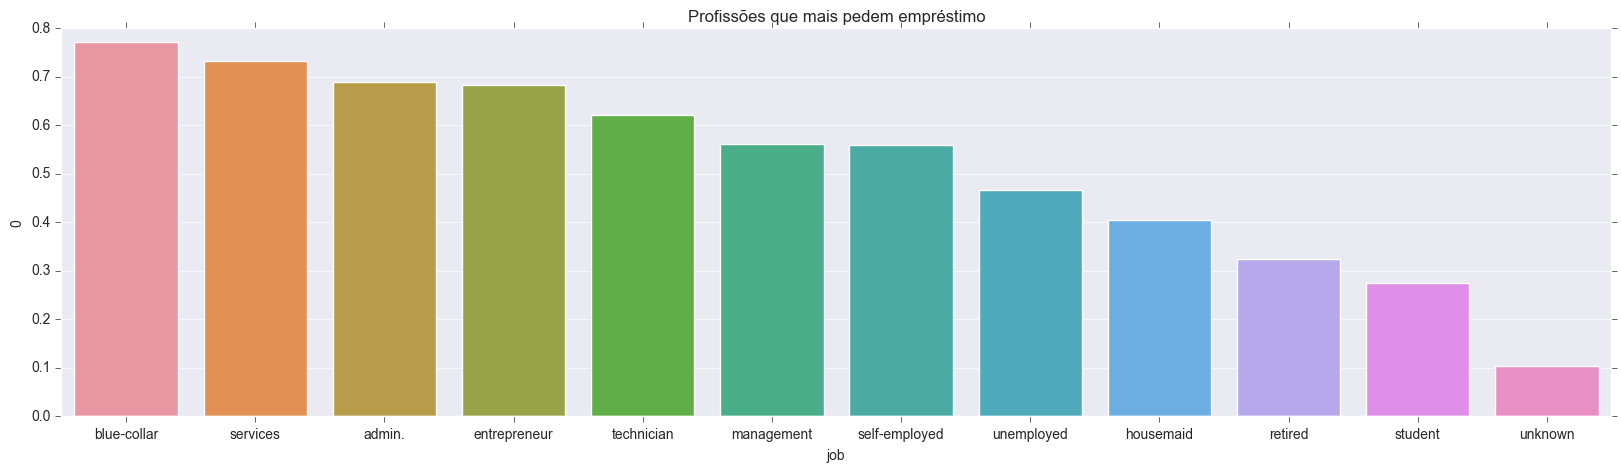

In [9]:
idx = df_job_pers_perc.index
prob = pd.DataFrame(data=df_job_pers_perc.values + df_job_hous.values - df_job_pers_perc.values*df_job_hous.values, index=idx)

plt.figure(figsize=(20,5))
plt.title('Profissões que mais pedem empréstimo')
sns.barplot(x='job', y=0, data=prob.reset_index().sort(columns=0, ascending=False))
plt.show()

E, portanto, $\hat{k}$ = 'blue-collar', seguida de 'services' e 'admin'.

In [10]:
pd.DataFrame(df[df['job'] == 'blue-collar'][['loan', 'housing']].applymap(lambda x: mapping[x]).sum(), columns=['Empréstimos'])

,Empréstimos
loan,1684
housing,7048


E os empréstimos imobiliários são os mais realizados.

___
<b>2.</b> Fazendo uma relação entre número de contatos e sucesso da campanha, quais são os pontos relevantes a serem observados?

O sucesso da campanha (atual) é denotada pela variável resposta $y$.

Primeiramente, iremos verificar qual a taxa de sucesso da campanha pelo número de contatos.

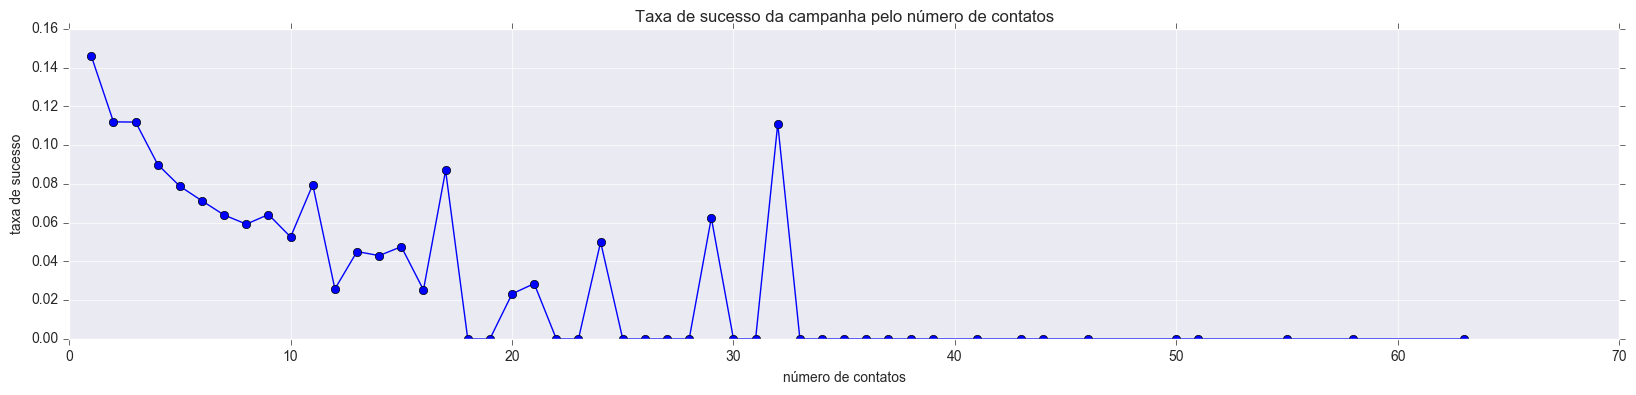

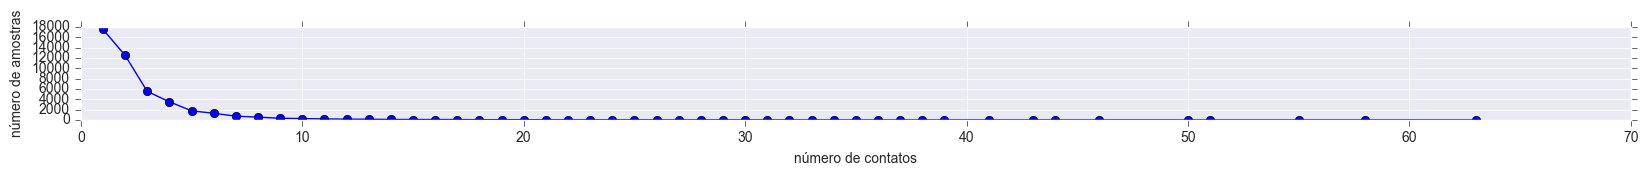

In [11]:
campaign_succ_rate = df[['campaign', 'y']].groupby('campaign').sum() / df[['campaign', 'y']].groupby('campaign').count()
x, y = campaign_succ_rate.index.tolist(), campaign_succ_rate.y.tolist()
total_contacts = df[['campaign', 'y']].groupby('campaign').count().y.tolist()

# plot da taxa de sucesso por contatos
plt.figure(figsize=(20,4))
plt.plot(x, y, 'bo-')
plt.ylabel('taxa de sucesso')
plt.xlabel('número de contatos')
plt.title('Taxa de sucesso da campanha pelo número de contatos')

# plot do número total de amostras
plt.figure(figsize=(20,1.2))
plt.plot(x, total_contacts, 'bo-')
plt.ylabel('número de amostras')
plt.xlabel('número de contatos')
plt.show()

O gráfico mostra que o número de amostras para um número de contatos maior que 10 é desprezível, então vamos melhorar a granularidade do gráfico.

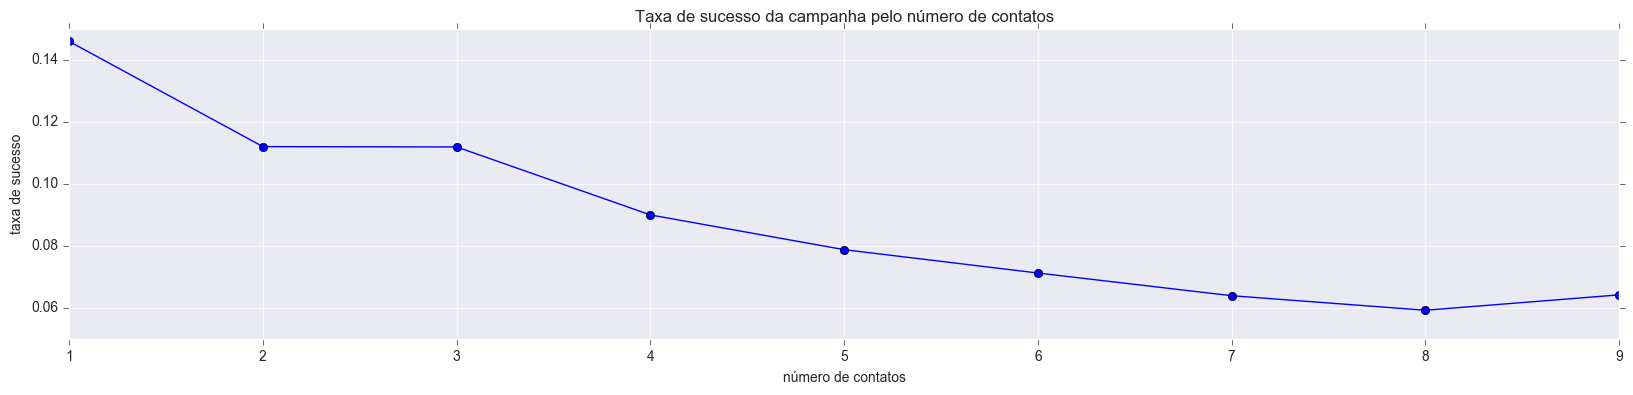

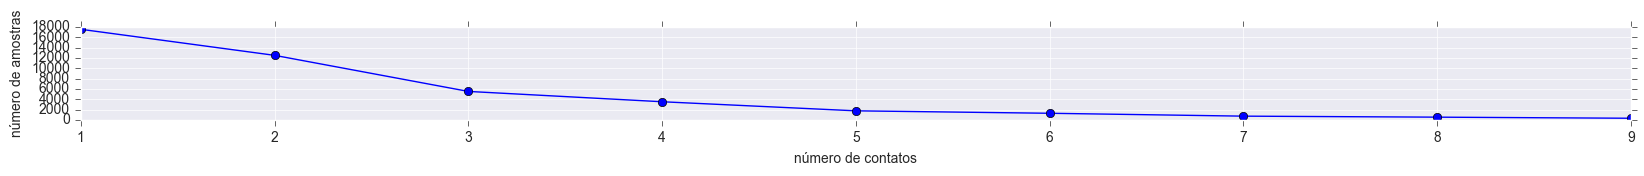

In [12]:
campaign_succ_rate = df[df['campaign'] < 10][['campaign', 'y']].groupby('campaign').sum() / df[df['campaign'] < 10][['campaign', 'y']].groupby('campaign').count()
x, y = campaign_succ_rate.index.tolist(), campaign_succ_rate.y.tolist()
total_contacts = df[df['campaign'] < 10][['campaign', 'y']].groupby('campaign').count().y.tolist()

# plot da taxa de sucesso por contatos
plt.figure(figsize=(20,4))
plt.plot(x, y, 'bo-')
plt.ylabel('taxa de sucesso')
plt.xlabel('número de contatos')
plt.title('Taxa de sucesso da campanha pelo número de contatos')

# plot do número total de amostras
plt.figure(figsize=(20,1.2))
plt.plot(x, total_contacts, 'bo-')
plt.ylabel('número de amostras')
plt.xlabel('número de contatos')
plt.show()

Do gráfico acima, nota-se que a adesão é maior com um menor número de contatos. 

Contudo, não sabemos se essa relação é preservada entre os diversos segmentos, isto é, poderia valer que estudantes aderissem mais à campanha com um maior número de contatos. 

Vamos verificar se essa relação se estabelece conforme os diversos atributos, começando pelos atributos categóricos.

In [13]:
#fazendo um pivoteamento para um atributo apenas para verificar o dataframe

#Os NaN's ocorrem pois o pivoteamento irá tirar a média, e portanto a não ocorrência de determinado # de campanhas leva a uma divisão por 0
df[df['campaign'] <= 15][['job', 'campaign', 'y']].pivot_table(index='campaign', values='y', columns='job')

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
campaign,,,,,,,,,,,,
1,0.149339,0.087978,0.083770,0.108545,0.168816,0.282026,0.162029,0.104637,0.330317,0.143175,0.182927,0.186916
2,0.114766,0.073144,0.087533,0.085044,0.134840,0.215311,0.102689,0.089047,0.240664,0.105240,0.140056,0.089552
3,0.100000,0.067451,0.073892,0.093567,0.131419,0.196581,0.118557,0.087318,0.284483,0.125272,0.174194,0.142857
4,0.106936,0.060241,0.105263,0.035398,0.106734,0.168750,0.079710,0.087097,0.309524,0.068966,0.115385,0.100000
5,0.049689,0.045570,0.084746,0.051724,0.117333,0.145833,0.044118,0.033113,0.250000,0.076412,0.121951,0.000000
6,0.068376,0.053957,0.062500,0.138889,0.092357,0.060000,0.071429,0.061538,0.235294,0.052632,0.076923,0.000000
7,0.051948,0.053571,0.034483,0.000000,0.096154,0.068966,0.031250,0.072464,0.142857,0.064516,0.076923,0.000000
8,0.107143,0.044248,0.000000,0.176471,0.106557,0.000000,0.000000,0.021277,0.111111,0.026786,0.000000,0.000000
9,0.100000,0.061538,0.066667,0.111111,0.070588,0.111111,0.083333,0.057143,0.000000,0.040000,0.000000,0.000000


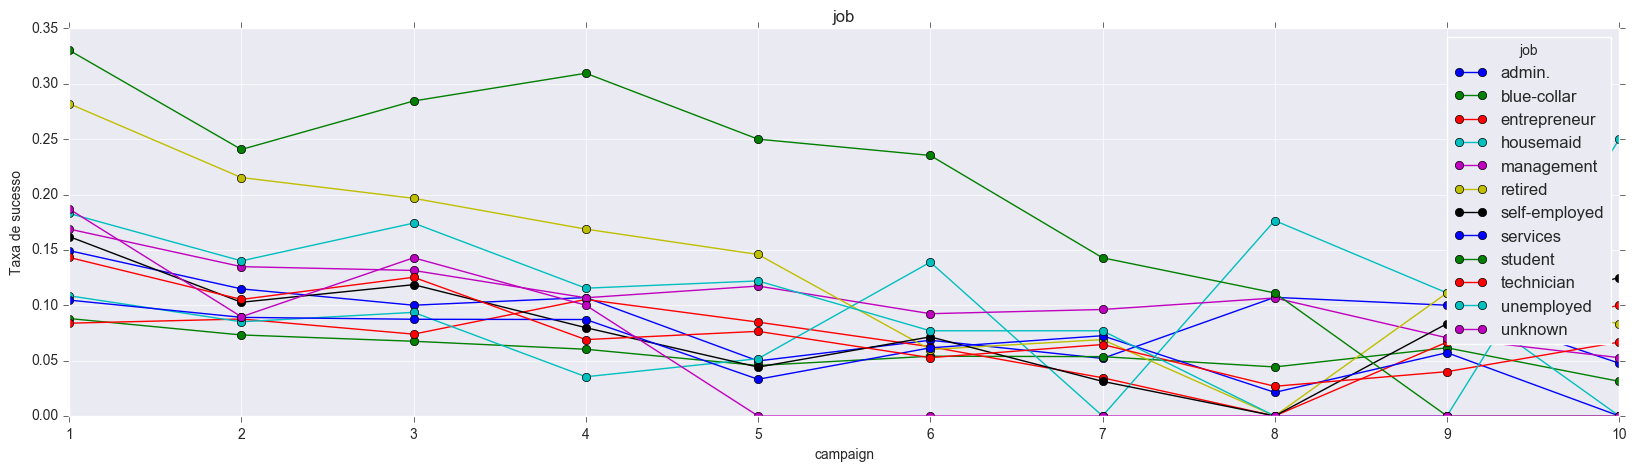

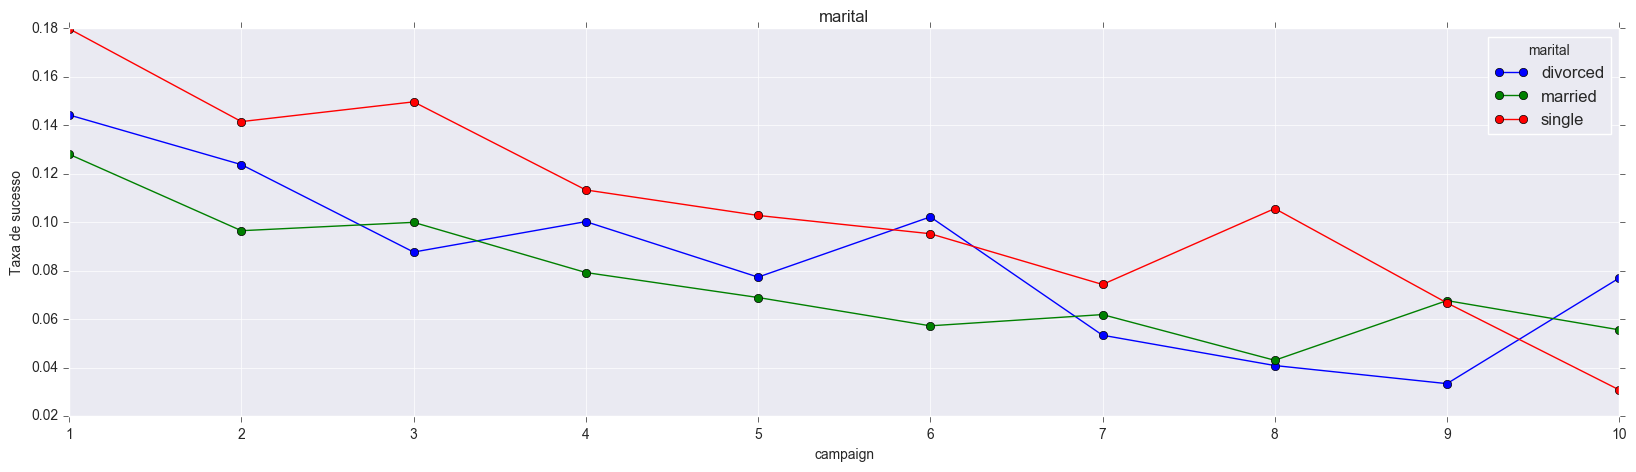

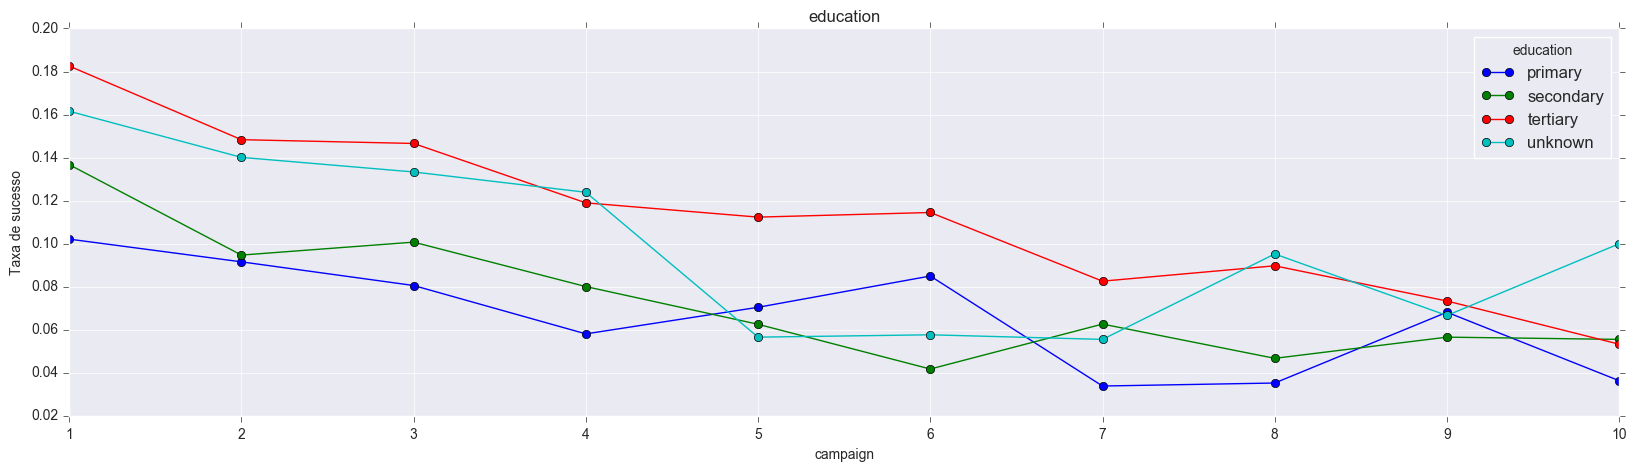

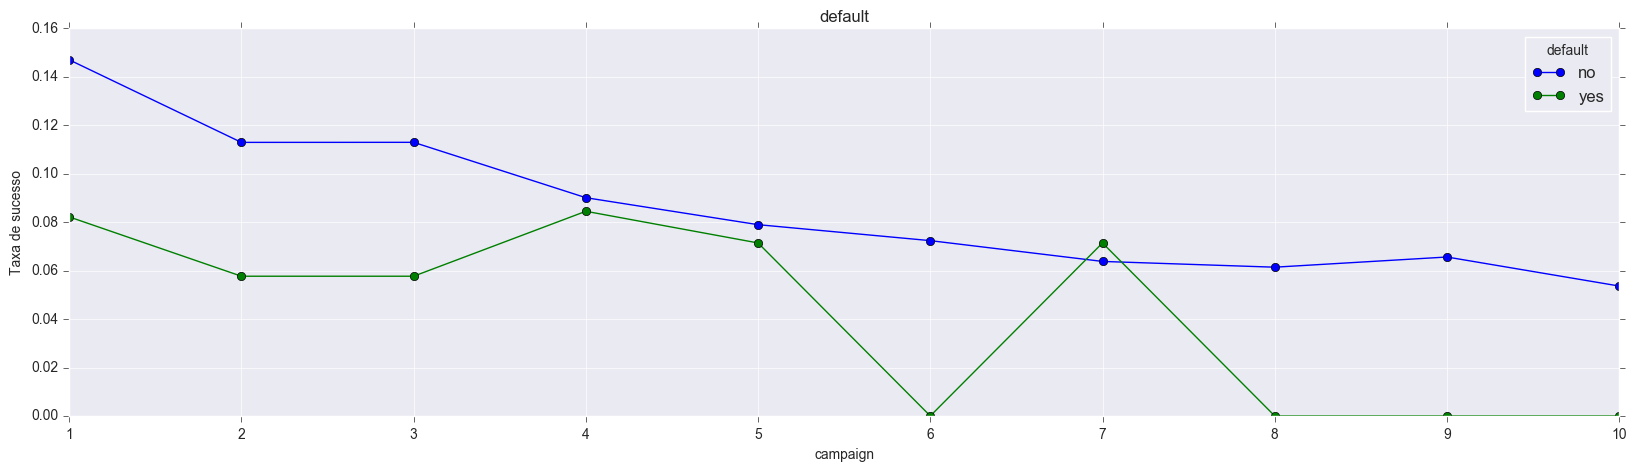

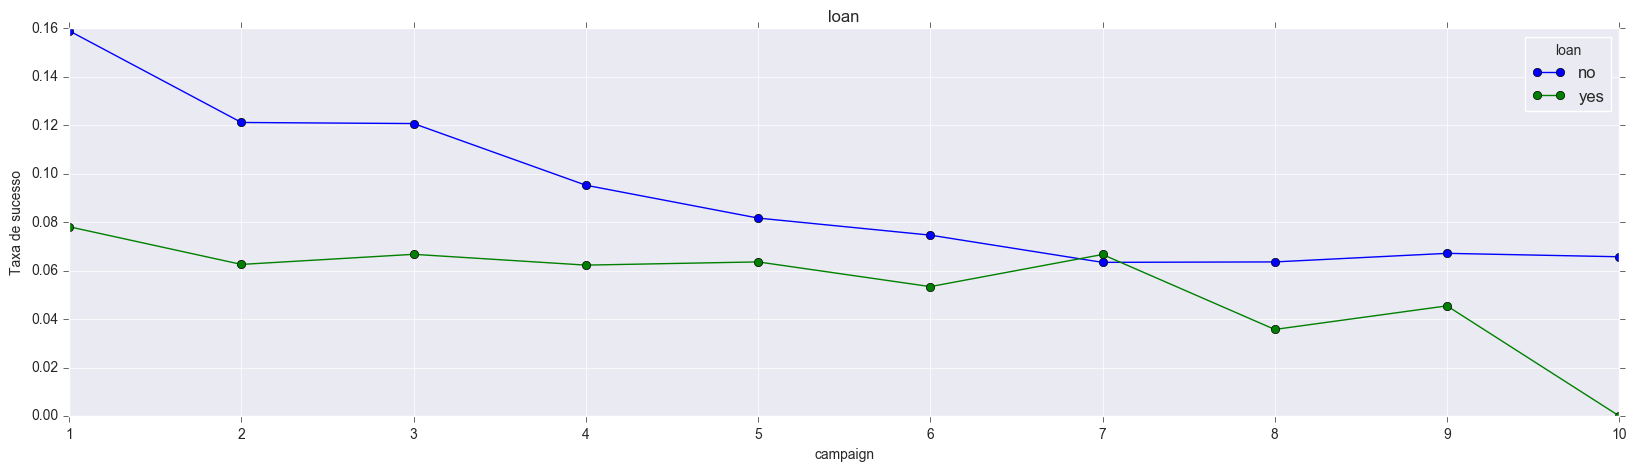

In [14]:
# Se considerarmos todas as amostras,
for x in ['job', 'marital', 'education', 'default', 'loan']:
    df[df['campaign'] <= 10][[x, 'campaign', 'y']].pivot_table(index='campaign', values='y', columns=x).\
    plot(title=x, figsize=(20,5), marker='o',xticks=[i for i in range(1, 11)]
    )
    plt.ylabel('Taxa de sucesso')
    plt.show()

Alguns pontos relevantes a serem levado em consideração tratam-se das profissões, educação e inadimplência.

No campo das profissões, os estudantes e os desempregados, que se tratam de profissões de alta taxa de adesão, aderem à campanha com um maior número de contato que a média. 

No campo da educação, clientes com apenas educação primária também tendem a aderir mais à campanha ao serem contatados mais vezes. 

Para os inadimplentes, também é interessante continuar contatando, uma vez que a taxa de adesão não diminui com o número de contatos.

Podemos agora realizar a mesma análise para os atributos numéricos. Vale lembrar, no entanto, que existem dados que são altamente correlacionados, como as profissões e as idades, e portanto algumas análises passam a ser redundantes. 

Abaixo, nota-se a existência de certa homogeneidade de idade em cada profissão.

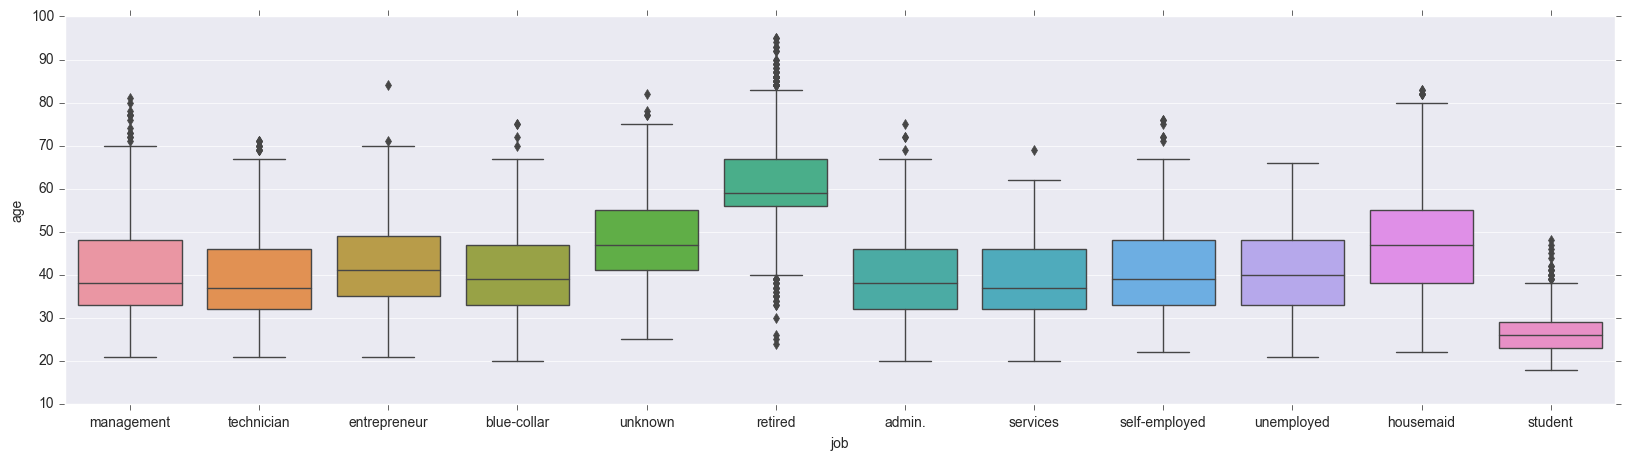

In [15]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='job', y='age', data=df[['age', 'job', 'y']])
plt.show()

In [16]:
# Criando intervalos para o balanço da conta
bins = [-2000, 0, 500, 1000, 2000, 5000, np.inf]
names = ['[-2000, 0]', '[0, 500]', '[500, 1000]', '[1000, 2000]', '[2000, 5000]', '[5000, inf)']

df['balance_range'] = pd.cut(df['balance'], bins, labels=names)
df[df['campaign'] <= 10][['balance_range', 'campaign', 'y']].pivot_table(index='campaign', values='y', columns='balance_range')

balance_range,"[-2000, 0]","[0, 500]","[500, 1000]","[1000, 2000]","[2000, 5000]","[5000, inf)"
campaign,,,,,,
1,0.083803,0.129474,0.157799,0.173366,0.200810,0.187446
2,0.062378,0.103742,0.109718,0.118788,0.176649,0.145078
3,0.071262,0.093906,0.123570,0.134211,0.162963,0.137536
4,0.055743,0.073353,0.089695,0.113978,0.136919,0.153061
5,0.050847,0.061341,0.122951,0.088106,0.105528,0.102041
6,0.051948,0.064588,0.045455,0.085227,0.122581,0.101266
7,0.108333,0.049430,0.043860,0.062500,0.067416,0.075472
8,0.045455,0.049751,0.051282,0.093333,0.090909,0.031250
9,0.052632,0.041667,0.046512,0.069767,0.083333,0.178571


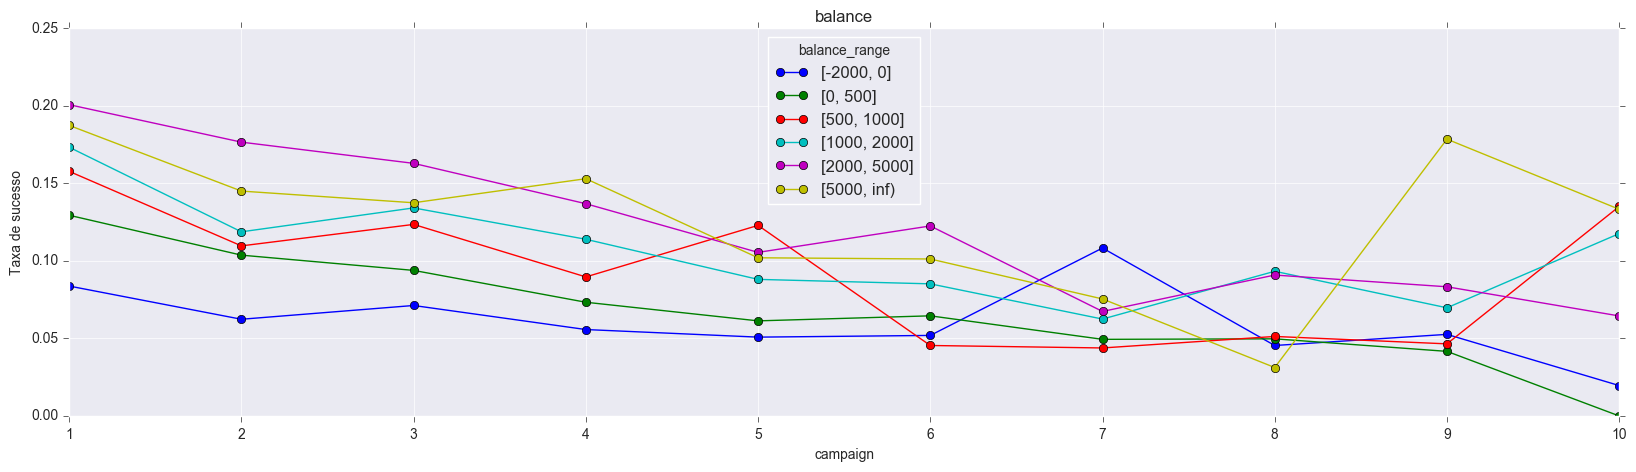

In [17]:
df[df['campaign'] <= 10][['balance_range', 'campaign', 'y']].pivot_table(index='campaign', 
                                                                         values='y', 
                                                                         columns='balance_range').plot(title='balance', 
                                                                                                       figsize=(20,5), 
                                                                                                       marker='o',
                                                                                                       xticks=[i for i in range(1, 11)])
plt.ylabel('Taxa de sucesso')
plt.show()

Analogamente ao fenômeno citado acima, pessoas com menor balanço na conta tenderão a aderir mais ao programa quando forem contatadas um maior número de vezes. 

Apesar disso, eu acredito que há uma relação entre menor balanço na conta e menor educação, vamos verificar brevemente.

In [18]:
df[['balance_range', 'education', 'y']].pivot_table(columns='education', index='balance_range', values='y')
ldf = df[['balance_range', 'education']].groupby(['balance_range', 'education']).size().reset_index()
ldf.columns = ['balance_range', 'education', 'quantity']
odf = ldf.groupby(['balance_range', 'education']).sum() / ldf.groupby(['balance_range']).sum()
odf.head(12
        )

quantity
balance_range education          
[-2000, 0]    primary    0.157170
              secondary  0.554363
              tertiary   0.252821
              unknown    0.035645
[0, 500]      primary    0.159109
              secondary  0.534696
              tertiary   0.268233
              unknown    0.037962
[500, 1000]   primary    0.140564
              secondary  0.521764
              tertiary   0.290672
              unknown    0.046999

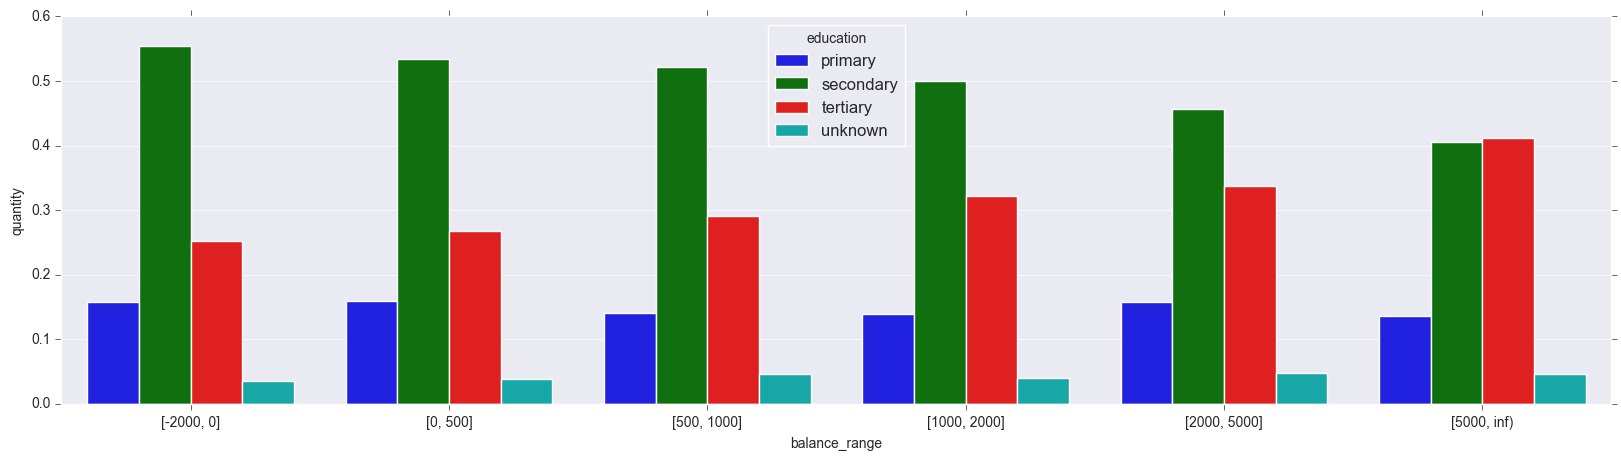

In [19]:
plt.figure(figsize=(20, 5))
sns.barplot(x='balance_range', y='quantity', hue='education', data=odf.reset_index())
plt.show()

Não é evidente que pessoas com educação mais baixa tendem a ter menor balanço na conta, a única coisa que podemos ver é que pessoas de maior educação possuem maior balanço na conta. Portanto, a relação que eu acreditava não se verificou.
___

<b>3.</b> Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações que você indica para otimizar a adesão?

Vamos primeiro colocar o 'número de ligações' e a 'taxa de sucesso por contatos' em escala, para que possamos refletir sobre o número de ligações a serem feitas.  

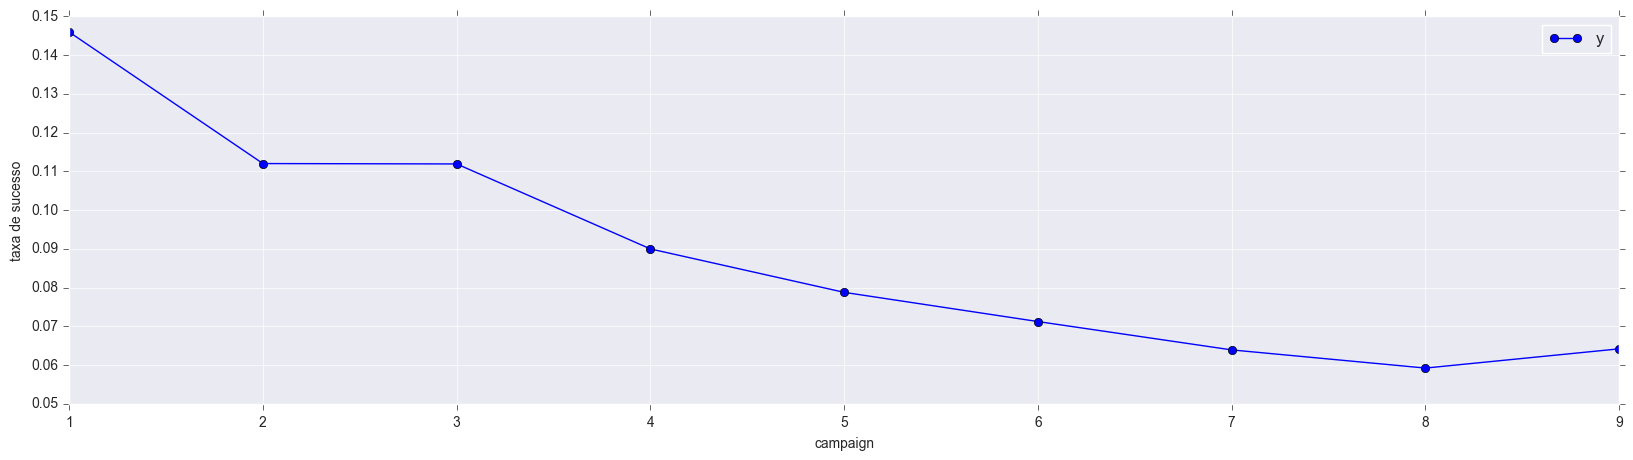

In [20]:
campaign_succ_rate.plot(figsize=(20, 5), marker='o')
plt.ylabel('taxa de sucesso')
plt.yticks([0.01*i for i in range(5, 16)])
plt.show()

Podemos notar que a taxa de sucesso decresce radicalmente conforme o número de ligações vai aumentando, quando realizam-se 4 contatos ao cliente, a taxa de sucesso de adesão será quase metade que a realização de apenas 1 contato. 

Portanto, poderia ser mais valoroso a tentativa de contatar outros clientes, ao invés de desgastar a imagem do banco devido à insistência, e manter as relações com o cliente estáveis, além de evitar custos adicionais com uma campanha incerta. 

Em média, poderiam ser realizados 3 contatos com o cliente, e no máximo 5. Após 5 contatos, a taxa de sucesso de adesão já é metade do que a maior taxa de sucesso, levando a um desgaste considerável com o cliente. Até 3 contatos, a taxa se mantém com certa estabilidade.

Ps: Vale lembrar que essa é uma resposta que desconsidera os mais diversos segmentos.
___

<b>4.</b> O resultado da campanha anterior tem relevância na campanha atual?

As variáveis que compreendem a campanha anterior são: 'pdays', 'previous' e 'poutcome'. 

Quando 'pdays' assume valor -1, então o cliente não foi contatado previamente, portanto, descartamos esses dados.

In [21]:
# descartando os clientes não contatados previamente.
pdf = df[df['pdays'] > 0]

Vamos verificar as distribuições brevemente.

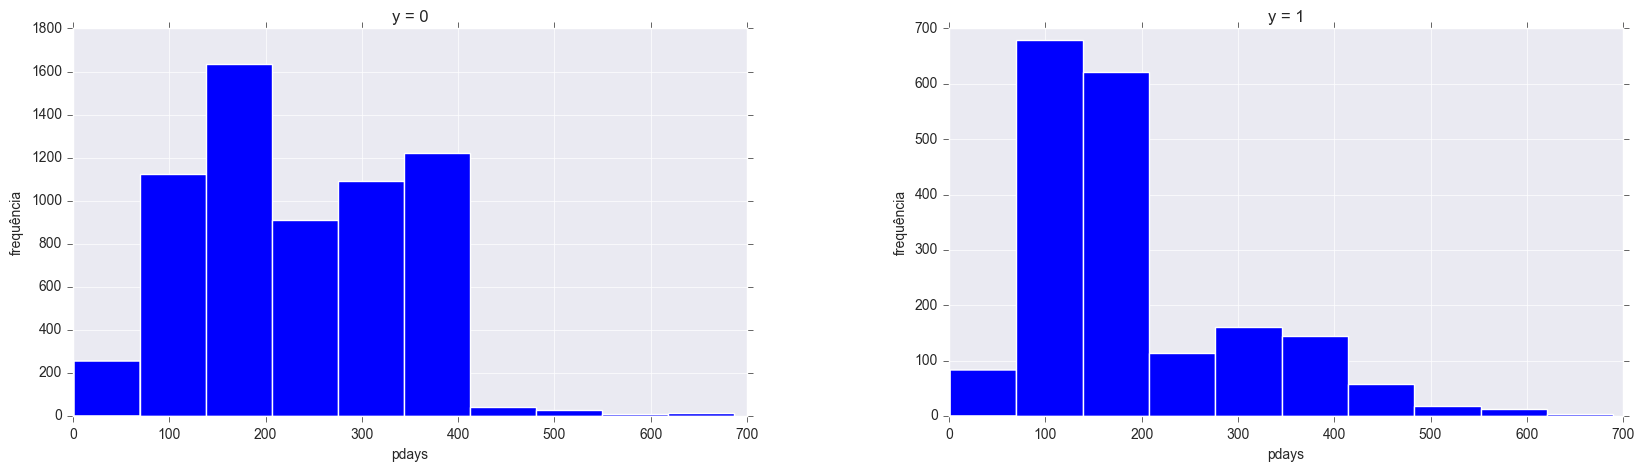

In [22]:
fig, ax = plt.subplots(1,2, figsize=(20,5),)

pdf[(pdf['y'] == 0) & (pdf['pdays'] < 700)][['pdays']].hist(ax=ax[0]); 
ax[0].set_title('y = 0')
ax[0].set_xlabel('pdays');
ax[0].set_ylabel('frequência')

pdf[(pdf['y'] == 1) & (pdf['pdays'] < 700)][['pdays']].hist(ax=ax[1]); 
ax[1].set_title('y = 1'); 
ax[1].set_xlabel('pdays');
ax[1].set_ylabel('frequência')

plt.show()

Podemos abordar a pergunta de duas formas:

(1) Se o cliente foi contatado anteriormente, há relevância na campanha atual?

(2) Se o cliente aderiu à campanha anterior, há relevância na campanha atual?

Respondendo (1): 

In [23]:
print('A probabilidade da campanha atual ser aderida, dado que o cliente não foi contatado previamente, é de {}%'.format( 
      100*np.round(df[df['pdays'] == -1][['y']].mean().iloc[0],3)))
print('A probabilidade da campanha atual ser aderida, dado que o cliente foi contatado previamente, é de {}%'.format( 
      100*np.round(df[df['pdays'] > 0][['y']].mean().iloc[0],3)))

A probabilidade da campanha atual ser aderida, dado que o cliente não foi contatado previamente, é de 9.2%
A probabilidade da campanha atual ser aderida, dado que o cliente foi contatado previamente, é de 23.1%


Portanto, se o cliente foi contatado previamente, provavelmente ele irá aderir à nova campanha. 

Respondendo (2):

In [24]:
jdf = df[(df['poutcome'] == 'success') | (df['poutcome'] == 'failure')]
ff = len(jdf[(jdf['y'] == 0) & (jdf['poutcome'] == 'failure')])/len(jdf)
sf = len(jdf[(jdf['y'] == 0) & (jdf['poutcome'] == 'success')])/len(jdf)
fs = len(jdf[(jdf['y'] == 1) & (jdf['poutcome'] == 'failure')])/len(jdf)
ss = len(jdf[(jdf['y'] == 1) & (jdf['poutcome'] == 'success')])/len(jdf)
confusion_matrix = pd.DataFrame(np.array([[ff, fs],[sf, ss]]), columns=['falha', 'sucesso'], index=['falha', 'sucesso'], )
confusion_matrix.index.name = 'Campanha Anterior'
confusion_matrix.columns.name = 'Campanha Atual'
confusion_matrix['total'] = confusion_matrix.sum(axis=1)
confusion_matrix.loc['total'] = confusion_matrix.sum(axis=0)
confusion_matrix

Campanha Atual,falha,sucesso,total
Campanha Anterior,,,
falha,0.667966,0.096382,0.764348
sucesso,0.083125,0.152527,0.235652
total,0.751092,0.248908,1.000000


A probabilidade do cliente aderir à nova campanha, dado que ele não aderiu à campanha anterior, é de 9.7%. 

Já a probabilidade do cliente aderir à nova campanha, dado que ele aderiu à campanha anterior, é de 15.3%.

Quantificando a relevância da campanha anterior na campanha atual:

Se o cliente aderiu à campanha atual, então a probabilidade dele ter aderido à última campanha é de $\frac{15.3\%}{15.3\% + 9.7\%} = 61.2\%$.

E portanto, as resposta para (1) e (2) é que a última campanha é relevante para a campanha atual. 

Por curiosidade, podemos verificar o perfil das adesões conforme o número de dias entre a campanha atual e a anterior. 

Em azul, temos a taxa de adesão à nova campanha pelo número de dias que passaram desde a campanha anterior. 

Em vermelho, temos o número total de pessoas que foram contatadas, e esse tracejado é importante para a captura de possíveis outliers nas taxas de sucesso. 

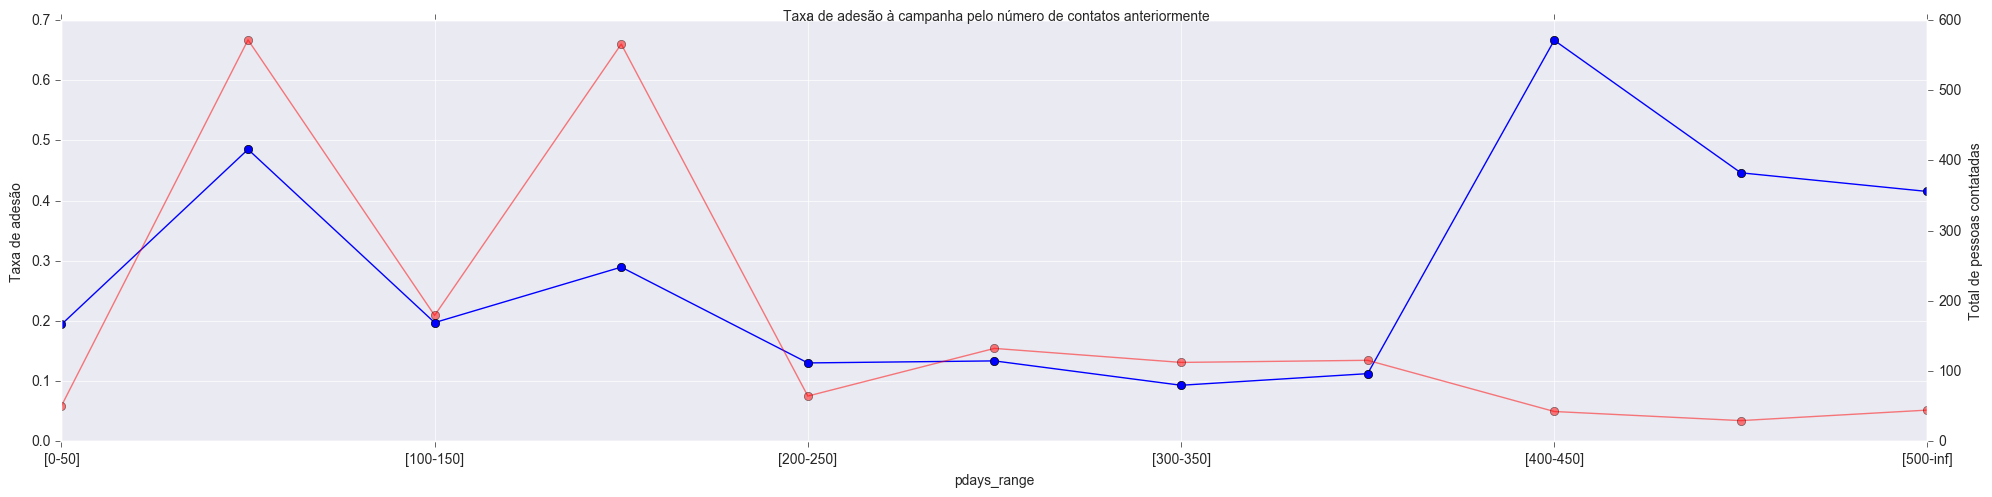

In [25]:
# Criando intervalos de 50 em 50 para o 'pdays'
b = list(np.arange(0, 510, 50)) + [np.inf]
l = ['[{}-{}]'.format(b[i-1], b[i]) for i in range(1, len(b)-1)] + ['[500-inf]']
pdf['pdays_range'] = pd.cut(pdf['pdays'], bins=b, labels=l)

# Plot das taxas
fig, ax1 = plt.subplots()
fig.suptitle('Taxa de adesão à campanha pelo número de contatos anteriormente')
pdf[['pdays_range', 'y']].pivot_table(index='pdays_range', values='y', aggfunc='mean').plot(ax=ax1, marker='o', figsize=(20,5))
ax1.set_ylabel('Taxa de adesão')
ax2 = ax1.twinx()
pdf[['pdays_range', 'y']].pivot_table(index='pdays_range', values='y', aggfunc='sum').plot(ax=ax2, grid=False, color='r', marker='o', alpha=0.5, figsize=(20,5))
ax2.set_ylabel('Total de pessoas contatadas')
fig.tight_layout()
plt.show()

Verifica-se que os intervalo de 75 a 100 dias, e de 400 a 500 dias, são os que otimizam o tempo de contato com cliente entre as campanhas, apesar de neste último termos um espaço amostral reduzido. 

___

5) Qual o fator determinante para que o banco exija um seguro de crédito?

Não entendi direito onde posso encontrar informações sobre exigências de seguro de crédito, pensei talvez estar relacionado com 'credit in default', isto é, com a inadimplência do cliente, mas mesmo não consegui estabelecer conexões. 

___
6) Quais são as características mais proeminentes de um cliente que possua
empréstimo imobiliário?

Uma forma de se extrair a importância das características, é utilizar uma árvore de classificação, e verificar quais características possuem menor critério de impureza (podendo tratar-se da entropia, do índice GINI ou uma métrica arbitrária). 

Analisa-se como estão balanceados os dados, neste caso, a variável resposta será 'housing', em que iremos binarizá-la para 0 e 1, representando 'no' e 'yes', respectivamente.

In [26]:
# binarizando dados
mapping = {'no':0, 'yes':1}
df['housing'] = df['housing'].apply(lambda x: mapping[x])
df['loan'] = df['loan'].apply(lambda x: mapping[x])
df['default'] = df['default'].apply(lambda x: mapping[x])

# one-hot-encoding
df_jobs = pd.get_dummies(df['job'])
df_educ = pd.get_dummies(df['education'])
df_mar  = pd.get_dummies(df['marital'])
df_def = pd.get_dummies(df['default'], prefix='default')
df_loan = pd.get_dummies(df['loan'], prefix='loan')

# dataframe frame processado
new_df = pd.concat([df[['housing', 'age', 'balance']], df_jobs, df_educ, df_mar, df_def, df_loan], axis=1)
new_df = new_df.drop(['unknown'], axis=1)

Verificando o balanceamento da variável resposta, para evitar a construção de um classificador viesado.

In [27]:
len(new_df[new_df['housing'] == 1])/len(new_df)

0.5558381809736569

Aparentemente há um bom balanceamento dos dados, vamos utilizar o modelo 'GradientBoostingClassifier' para realizar a classificação dos dados, e iremos fazer a validação utilizando um 10-Fold, verificando a curva ROC e a acurácia em cada fold.

In [28]:
new_df.columns

Index(['housing', 'age', 'balance', 'admin.', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services',
       'student', 'technician', 'unemployed', 'primary', 'secondary',
       'tertiary', 'divorced', 'married', 'single', 'default_0', 'default_1',
       'loan_0', 'loan_1'],
      dtype='object')

Fold-1 AUC: 0.60 acurácia 0.6455108359133127
              precision    recall  f1-score   support

           0       0.15      0.51      0.23       470
           1       0.92      0.66      0.77      4052

    accuracy                           0.65      4522
   macro avg       0.53      0.58      0.50      4522
weighted avg       0.84      0.65      0.71      4522

--------------------
Fold-2 AUC: 0.62 acurácia 0.7148860871488609
              precision    recall  f1-score   support

           0       0.15      0.37      0.21       471
           1       0.91      0.75      0.83      4050

    accuracy                           0.71      4521
   macro avg       0.53      0.56      0.52      4521
weighted avg       0.83      0.71      0.76      4521

--------------------
Fold-3 AUC: 0.65 acurácia 0.49657155496571553
              precision    recall  f1-score   support

           0       0.81      0.34      0.48      3093
           1       0.37      0.83      0.51      1428

    

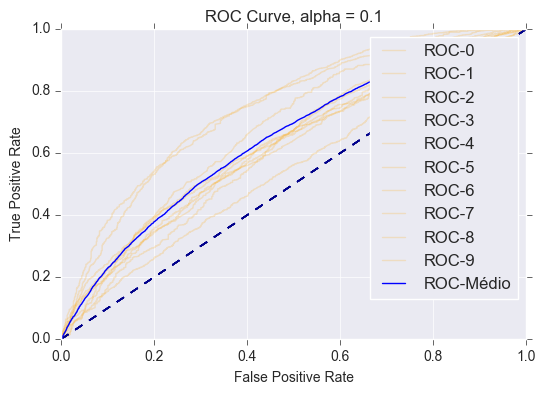

alpha : 0.1, AUC : 0.6484877694503083, Acurácia : 0.5955840409016608


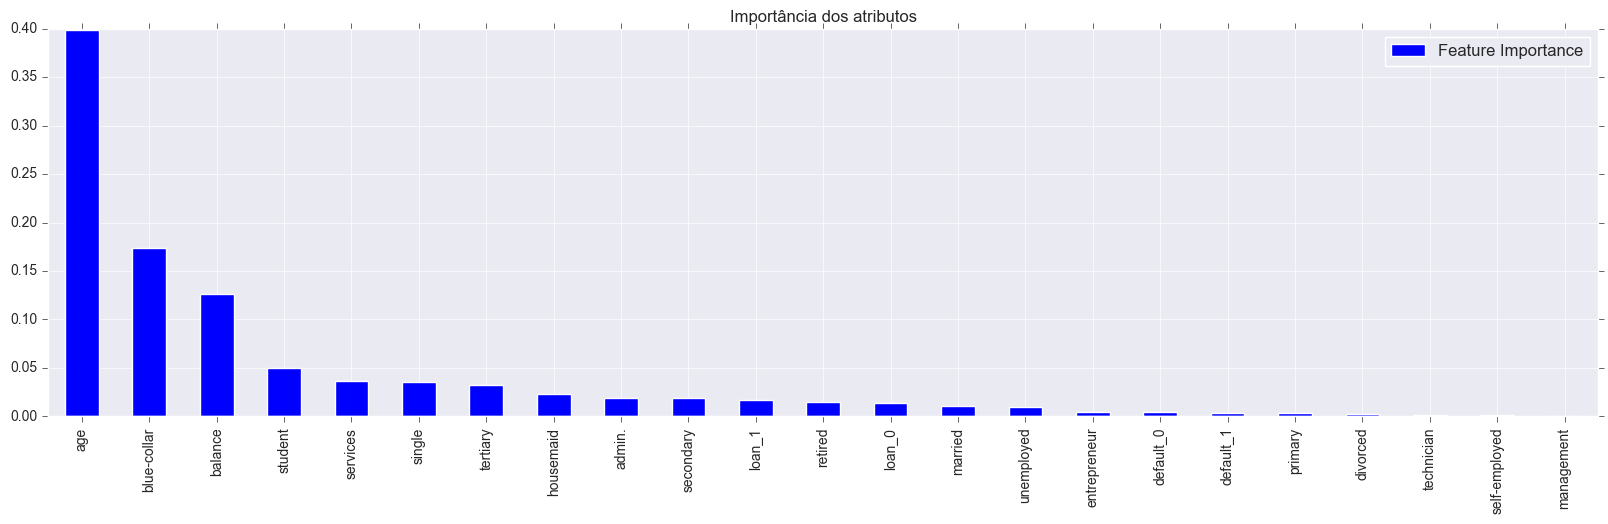

In [29]:
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, roc_auc_score, accuracy_score

X = new_df.drop('housing', axis=1).as_matrix()
y = new_df['housing']

kf = KFold(n_splits=10)
acc = []
fpr_l, tpr_l, auc_l = [], [], []
alpha = 0.1

feat_import = []

fold = 0
for train_index, test_index in kf.split(X):
    fold+=1
    
    # Separando os conjuntos de treino e teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Criação do modelo
    gbm = GradientBoostingClassifier(learning_rate=alpha)
    gbm.fit(X_train, y_train)
    feature_importances = gbm.feature_importances_
    feat_import.append(feature_importances)
    
    # Valores de saída
    y_pred = gbm.predict(X_test)
    probs = gbm.predict_proba(X_test)  
    probs = probs[:, 1]  

    # armazenando avaliação do modelo
    auc = roc_auc_score(y_test, probs) 
    auc_l.append(auc)
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    acc.append(accuracy)
    
    # Reportando a avaliação de cada fold
    print('Fold-{}'.format(fold), 'AUC: %.2f' % auc, 'acurácia', accuracy)  
    print(classification_report(y_true=y_test, y_pred=y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    fpr_l.append(fpr)
    tpr_l.append(tpr)
    print('---------------------------------')

# Plot da curva ROC de cada fold
for i in range(len(fpr_l)):
    plt.plot(fpr_l[i], tpr_l[i], color='orange', alpha=0.2, label='ROC-{}'.format(i))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, alpha = {}'.format(alpha))

# Plot da curva ROC média
mean_fpr = [float(sum(l))/len(l) for l in zip(*fpr_l)]
mean_tpr = [float(sum(l))/len(l) for l in zip(*tpr_l)]
plt.plot(mean_fpr, mean_tpr, label='ROC-Médio')
plt.legend()
plt.show()
print('alpha : {}, AUC : {}, Acurácia : {}'.format(alpha, np.mean(auc_l), np.mean(acc)))

# Importância de cada atributo
labels = new_df.drop('housing', axis=1).columns
fi_df = pd.DataFrame(data=[float(sum(l))/len(l) for l in zip(*feat_import)], index=labels, columns=['Feature Importance'])
fi_df.sort_values(by='Feature Importance', ascending=False).plot(kind='bar', figsize=(20,5))
plt.title('Importância dos atributos')
plt.show()

Apesar desse classificador não ser tão bom, ele consegue capturar algum efeito dos dados. 

Das características que foram mais proeminentes, temos a idade, profissão e o balanço da conta. 